<a href="https://colab.research.google.com/github/ItayG6454/Time-Series-Course/blob/main/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
df = pd.read_csv("/content/drive/MyDrive/1. Study/MSc/TimeSeries/Final Project/charts.csv")

In [43]:
df.sample(4)

,title,rank,date,artist,url,region,chart,trend,streams
15247553,Marlboro Nights,29,2019-08-29,Lonely God,https://open.spotify.com/track/3jj0kpwNbVZfsg6...,India,viral50,MOVE_DOWN,NaN
2665506,Yad Eller,116,2018-09-08,maNga,https://open.spotify.com/track/0ckzNo4VIOTDNfu...,Turkey,top200,MOVE_UP,13970.0
15624536,Honey Boo,179,2020-09-12,"CNCO, Natti Natasha",https://open.spotify.com/track/0P0UtGDZpUMWoFC...,Bolivia,top200,MOVE_UP,2152.0
13224464,Estamos Bien,4,2018-07-20,Bad Bunny,https://open.spotify.com/track/7glCSQqV5o6NU88...,Nicaragua,viral50,SAME_POSITION,NaN


In [44]:
df['artist'].value_counts()[1:20]

artist
Billie Eilish      251825
Post Malone        211272
Bad Bunny          203403
Ariana Grande      189914
Dua Lipa           187085
Drake              177380
Imagine Dragons    157900
XXXTENTACION       155458
BTS                154338
The Weeknd         153292
Justin Bieber      130397
Travis Scott       122980
Juice WRLD         121933
Maluma             110762
Shawn Mendes       108786
Harry Styles       107539
Maroon 5           105610
Doja Cat           104325
Lewis Capaldi      101700
Name: count, dtype: int64

## Converting to weekly data

In [45]:
df['date'] = pd.to_datetime(df['date'])
df = df[df['chart'] == 'top200']
df = df[['rank', 'date', 'artist', 'region', 'streams']]
ed_glob_df = df[(df['region'] == 'Global') & (df['artist'] == 'Ed Sheeran')]
tmp = ed_glob_df[['date','streams']].groupby(['date']).sum().reset_index()
# Resample to weekly frequency and calculate the average of 'streams'
tmp.set_index('date', inplace=True)
weekly_streams = tmp.resample('W').sum()

In [ ]:
weekly_streams

## Part 2 -  Model Fitting

### Model 1 - Fourier Analysis


```
# This is formatted as code
```



In [52]:
N = len(weekly_streams)
T = 1 / 52  # Sampling period in weeks

# Compute Fourier Transform
y = weekly_streams['streams'].values
yf = np.fft.fft(y)
xf = np.fft.fftfreq(N, T)

print("Length of data (N):", N)
print("Size of Fourier coefficients array (yf):", yf.size)
print("Size of frequencies array (xf):", xf.size)
# print("Indices used:", indices)


Length of data (N): 261
Size of Fourier coefficients array (yf): 261
Size of frequencies array (xf): 261


In [53]:
xf

array([  0.        ,   0.19923372,   0.39846743,   0.59770115,
         0.79693487,   0.99616858,   1.1954023 ,   1.39463602,
         1.59386973,   1.79310345,   1.99233716,   2.19157088,
         2.3908046 ,   2.59003831,   2.78927203,   2.98850575,
         3.18773946,   3.38697318,   3.5862069 ,   3.78544061,
         3.98467433,   4.18390805,   4.38314176,   4.58237548,
         4.7816092 ,   4.98084291,   5.18007663,   5.37931034,
         5.57854406,   5.77777778,   5.97701149,   6.17624521,
         6.37547893,   6.57471264,   6.77394636,   6.97318008,
         7.17241379,   7.37164751,   7.57088123,   7.77011494,
         7.96934866,   8.16858238,   8.36781609,   8.56704981,
         8.76628352,   8.96551724,   9.16475096,   9.36398467,
         9.56321839,   9.76245211,   9.96168582,  10.16091954,
        10.36015326,  10.55938697,  10.75862069,  10.95785441,
        11.15708812,  11.35632184,  11.55555556,  11.75478927,
        11.95402299,  12.1532567 ,  12.35249042,  12.55

<ipython-input-56-29f42147c849>:36: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax2.stem(xf[:N//2], np.abs(yf[:N//2]), use_line_collection=True)


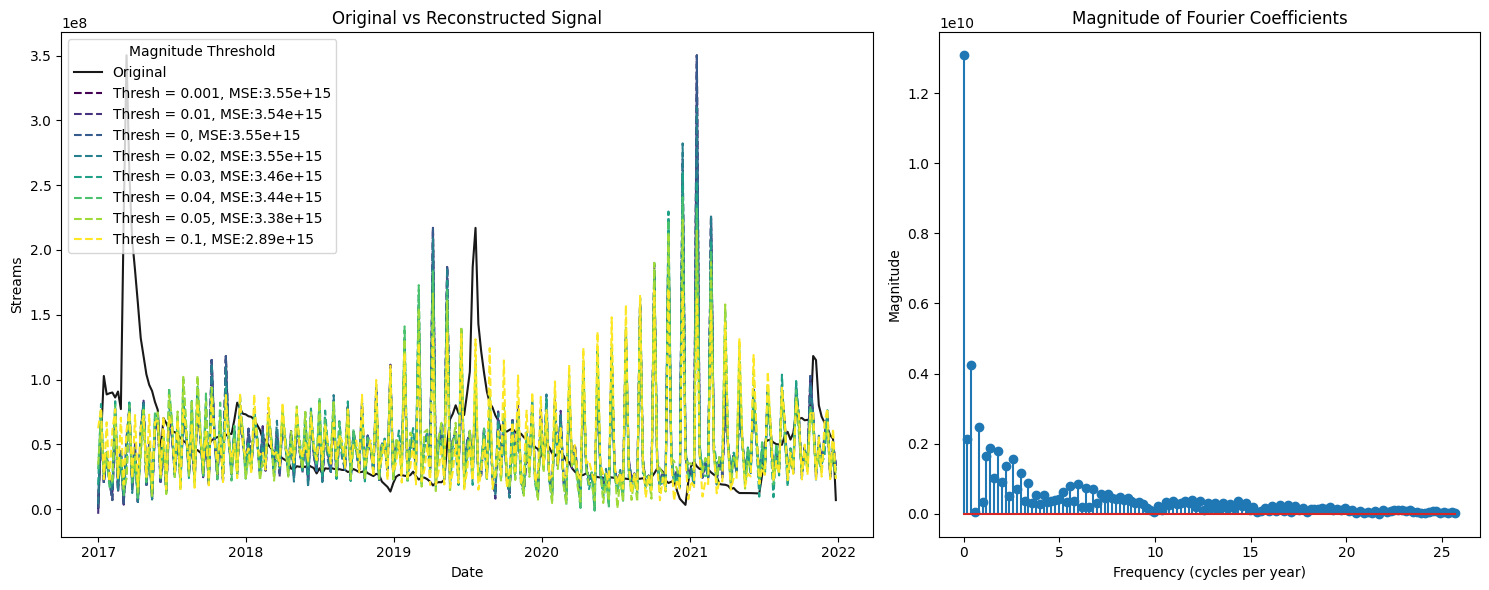

In [56]:
# Set up a grid layout
plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[60, 40])

# Plot original and reconstructed data
ax1 = plt.subplot(gs[0])
ax1.plot(weekly_streams.index, y, label='Original', alpha=0.9, color='black')

# Tuning magnitude threshold
thresholds = [0.001 , 0.01,0,0.02,0.03,0.04,0.05,0.1]
colors = cm.viridis(np.linspace(0, 1, len(thresholds)))

for magnitude_threshold, color in zip(thresholds, colors):
    significant_indices = np.where(np.abs(yf) > magnitude_threshold * np.max(np.abs(yf)))[0]

    # Reconstruct time series with significant coefficients only
    reconstruction = np.zeros(N)
    for idx in significant_indices:
        amplitude = np.abs(yf[idx]) / N
        phase = np.angle(yf[idx])
        reconstruction += amplitude * np.cos(2 * np.pi * xf[idx] * np.arange(N) + phase)

    # Calculating MSE for prediction
    mse = np.mean((weekly_streams['streams'] - reconstruction)**2)

    ax1.plot(weekly_streams.index, reconstruction, label=f'Thresh = {magnitude_threshold}, MSE:{mse:.2e}', linestyle='--', color=color)

# Plot Series with recostruction
ax1.legend(title='Magnitude Threshold')
ax1.set_title("Original vs Reconstructed Signal")
ax1.set_xlabel("Date")
ax1.set_ylabel("Streams")

# Plot Fourier Coefficients
ax2 = plt.subplot(gs[1])
ax2.stem(xf[:N//2], np.abs(yf[:N//2]), use_line_collection=True)
ax2.set_title('Magnitude of Fourier Coefficients')
ax2.set_xlabel('Frequency (cycles per year)')
ax2.set_ylabel('Magnitude')

plt.tight_layout()
plt.show()


Threshold:0.03
	Training based:0 --> 130, Tesing based:130 --> 156, MSE:8521847745814230.0
	Training based:0 --> 156, Tesing based:156 --> 182, MSE:1.1525271747096142e+16
	Training based:0 --> 182, Tesing based:182 --> 208, MSE:1.3085509998465674e+16
	Training based:0 --> 208, Tesing based:208 --> 234, MSE:1.3416603264303294e+16
	Training based:0 --> 234, Tesing based:234 --> 260, MSE:7097023802790895.0
Threshold: 0.03, Average MSE: 10729251311694048.00000
Threshold:0.05
	Training based:0 --> 130, Tesing based:130 --> 156, MSE:7717860562926107.0
	Training based:0 --> 156, Tesing based:156 --> 182, MSE:1.0628309450618084e+16
	Training based:0 --> 182, Tesing based:182 --> 208, MSE:1.2471022493046148e+16
	Training based:0 --> 208, Tesing based:208 --> 234, MSE:1.2552348810516428e+16
	Training based:0 --> 234, Tesing based:234 --> 260, MSE:6443402411288201.0
Threshold: 0.05, Average MSE: 9962588745678994.00000
Threshold:0.07
	Training based:0 --> 130, Tesing based:130 --> 156, MSE:7625692

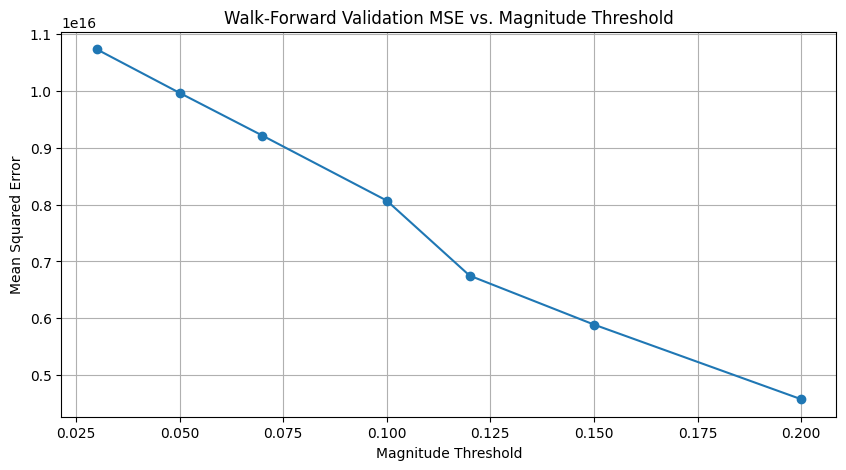

In [50]:
from sklearn.metrics import mean_squared_error

# Parameters
thresholds = [0.03, 0.05, 0.07, 0.1, 0.12, 0.15, 0.2]
initial_train_size = int(len(y) * 0.5)  # Start with 50% of data as training
validation_size = int(len(y) * 0.1)  # Each validation step uses the next 20% of data

# Placeholder for scores
scores = np.zeros(len(thresholds))

# Cross-validation loop
for i, threshold in enumerate(thresholds):
    mse_scores = []
    print(f"Threshold:{threshold}")
    for start in range(initial_train_size, len(y) - validation_size, validation_size):
        # Define the training and validation indices
        train_indices = np.arange(0, start)
        val_indices = np.arange(start, start + validation_size)

        # Perform Fourier transformation only on training data
        yf_train = np.fft.fft(y[train_indices])
        xf_train = np.fft.fftfreq(len(train_indices), 1)

        # Filter coefficients based on threshold
        significant_indices = np.where(np.abs(yf_train) > threshold * np.max(np.abs(yf_train)))[0]
        reconstruction = np.zeros(len(val_indices))
        for idx in significant_indices:
            amplitude = np.abs(yf_train[idx]) / len(train_indices)
            phase = np.angle(yf_train[idx])
            reconstruction += amplitude * np.cos(2 * np.pi * xf_train[idx] * np.arange(len(val_indices)) + phase)

        # Calculate MSE for the validation segment
        mse = mean_squared_error(y[val_indices], reconstruction)
        print(f"\tTraining based:0 --> {start}, Tesing based:{start} --> {start + validation_size}, MSE:{mse}")
        mse_scores.append(mse)

    # Average MSE for this threshold
    scores[i] = np.mean(mse_scores)
    print(f'Threshold: {threshold:.2f}, Average MSE: {scores[i]:.5f}')

# Find the best threshold
best_threshold = thresholds[np.argmin(scores)]
print(f'Best threshold: {best_threshold:.2f}, Lowest MSE: {min(scores):.5f}')

# Optional: Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(thresholds, scores, marker='o')
plt.title('Walk-Forward Validation MSE vs. Magnitude Threshold')
plt.xlabel('Magnitude Threshold')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()


### Performing 2 months predicting using the Fourier model

First,remmeber that  we need to compute Fourier Transform on full dataset, we can use $y,xf,yf$ from before. \
So all we need is to use the treshold we found to subset the sagnificants coeefients of the fourier series:

In [48]:
significant_indices = np.where(np.abs(yf) > 0.03 * np.max(np.abs(yf)))[0]
significant_indices

array([  0,   1,   2,   4,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  17,  19,  21,  25,  26,  28,  30,  32,  34,  36,  37,  38,
        39,  40,  41,  43, 218, 220, 221, 222, 223, 224, 225, 227, 229,
       231, 233, 235, 236, 240, 242, 244, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 257, 259, 260])

Predicting 2 months ahead:

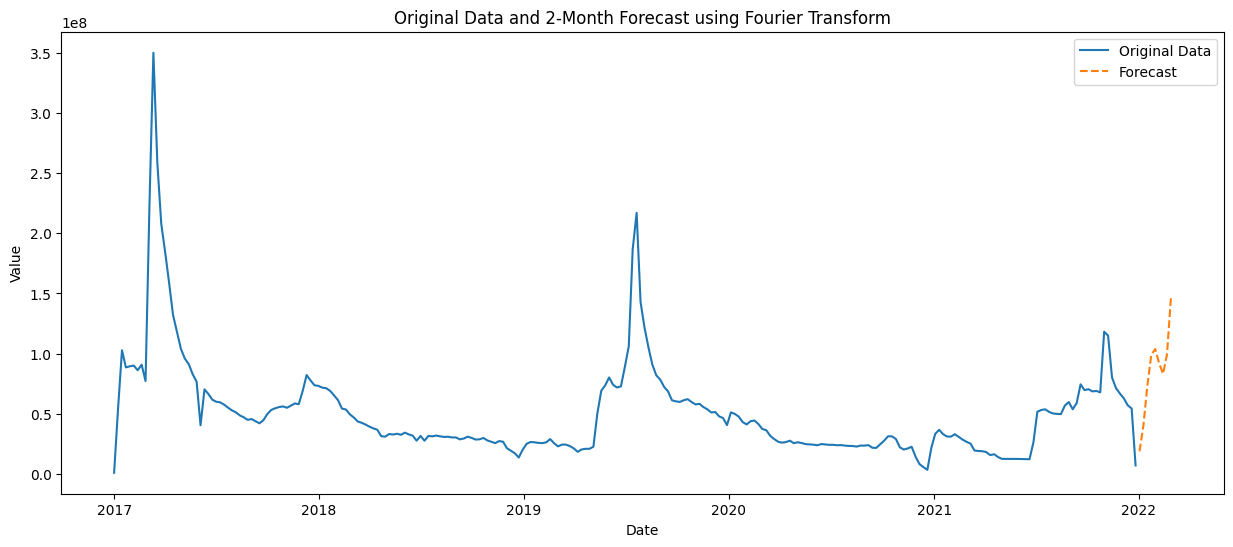

In [49]:
start_date = pd.to_datetime('2017-01-01')

end_date = pd.to_datetime('2021-12-31')
N = (end_date - start_date).days // 7 + 1

# Prediction length for the first two months of 2022 (approximately 9 weeks)
prediction_length = 9
reconstruction = np.zeros(N + prediction_length)
time_vector = np.arange(N + prediction_length)

# Your Fourier transform results, assuming `yf` for amplitudes and `xf` for frequencies
for idx in significant_indices:
    amplitude = np.abs(yf[idx]) / N
    phase = np.angle(yf[idx])
    reconstruction += amplitude * np.cos(2 * np.pi * xf[idx] * time_vector + phase)

# Create date range for both original and forecast data, weekly frequency
total_dates = pd.date_range(start=start_date, periods=N + prediction_length, freq='W')

# Plotting the original data and the forecast
plt.figure(figsize=(15, 6))
plt.plot(total_dates[:N], y, label='Original Data')  # Plot original data
plt.plot(total_dates[N:], reconstruction[-prediction_length:], label='Forecast', linestyle='--')  # Plot forecast
plt.legend()
plt.title('Original Data and 2-Month Forecast using Fourier Transform')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


### Model 2 - ARIMA Analysis

In [59]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00


In [60]:
import pmdarima as pm
from pmdarima import auto_arima

# Load your data
# weekly_streams = pd.read_csv('your_data.csv')

# Automatic ARIMA Modeling
auto_model = auto_arima(weekly_streams['streams'],
                        start_p=0, start_q=0,
                        test='adf',       # Use adf test to find optimal 'd'
                        max_p=5, max_q=5, # Maximum p and q
                        m=1,              # Frequency of the series
                        d=None,           # Let model determine 'd'
                        seasonal=False,   # No seasonality, you might want to change this if your data is seasonal
                        stepwise=True,    # Stepwise algorithm
                        trace=True,       # Print results
                        error_action='ignore',
                        suppress_warnings=True,
                        information_criterion='aic')  # Can choose 'aic', 'bic', 'hqic', whichever suits your needs

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9428.189, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9414.523, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9390.132, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9426.192, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9377.409, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9377.544, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9374.055, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9373.255, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9463.393, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9469.396, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=9371.184, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9388.126, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9371.862, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=9458.217, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]          